# Práctica Reinforcement Learning

Beatriz Torreiro Mosquera

In [1]:
import ipympl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from collections import namedtuple
import os

### Carga del environment

In [2]:
env = gym.make("Acrobot-v1")
env.seed(123)
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def get_height(state):
    cos_a, sin_a, cos_b, sin_b , _ , _ = state
    return -cos_a - (cos_a*cos_b - sin_a*sin_b)

### Deep Q-Learning

In [4]:
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        #we will only use 2 linear layers here since our environment is quite simple
        self.lin1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.lin2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.lin1,
            self.lin2,
        )
        return model(x)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

In [6]:
def eps_greedy_policy(q_values, eps):
    policy = np.ones([q_values.shape[0]])
    best_action = np.argmax(q_values)
    policy = eps * policy/len(policy)
    policy[best_action] += 1 - eps
    return policy

In [7]:
def train(env,model, epsilon = 0.3 ,gamma = 0.99, steps =300,episodes=500,learning_rate=0.001 ,successful_episodes=0 ,visual = False):
    #set this variable to True to render the training session
    visualization = visual
    
    
    #Parameters
    state = env.reset()
    loss_history = []
    reward_history = []

    #keep tracking best height of each episode and total rewards of each episode
    best_episode_height = []
    rewards = []

    # Initialize DQN_model
    model1 = model
#     model1.apply(weights_init)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model1.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    #close previous environment (in case, we haven't close any environment)
    env.close()

    #the training starts here
    for episode in trange(episodes):
        running_reward = 0
        episode_loss = 0
        episode_reward = 0
        max_height = -2
        state = env.reset()

        for s in range(steps):
            # render the environment every 100 episodes when visualization variable is True
            if episode % 100 == 0 and episode > 0 and visualization==True:
                env.render()

            # get Q-values of the input state from the model
            Q = model1(Variable(torch.from_numpy(state).type(torch.FloatTensor)))

            # Choose epsilon-greedy action
            action = np.random.choice( np.arange(len(Q)), p = eps_greedy_policy(Q.detach().numpy(), epsilon))
            

            # get the next state and reward
            state_1, reward, terminal, _ = env.step(action)
            running_reward += reward

            # Find max Q of the next state from predicted Q-values of our model
            Q1 = model1(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
            maxQ1, _ = torch.max(Q1, -1)

            # Create target Q value for training the policy
            Q_target = Q.clone()
            Q_target = Variable(Q_target)
            Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)

            # Calculate loss
            loss = loss_fn(Q, Q_target)

            # Update policy
            model1.zero_grad()
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()
            episode_reward += reward

            #compute height of the current step 
            current_height = get_height(state)

            #update max_height
            if current_height > max_height:
                max_height = current_height

            #reach terminal
            if terminal:
                #height of next state
                next_height = get_height(state_1)

                if next_height > max_height:
                    max_height = next_height

                #if terminal is goal state
                if next_height > 1:
                    #success steps count
                    successful_episodes += 1

                    #reduce epsilon everytime we exceed goal height
                    epsilon *= .995

                    # Adjust learning rate
                    scheduler.step()
                break
            else:
                state = state_1

        #record best height of this episode and its reward
        best_episode_height.append(max_height)
        reward_history.append(running_reward)

    print('successful episodes: {:d} - {:.4f}%'.format(successful_episodes, successful_episodes/episodes*100))
    return model, best_episode_height, reward_history


In [8]:
model1 = QNN()
model1, best_episode_height, reward_history = train(env,model1,episodes=1000)

100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s]

successful episodes: 925 - 92.5000%


In [9]:
import seaborn as sns
sns.set()

Text(0, 0.5, 'Height')

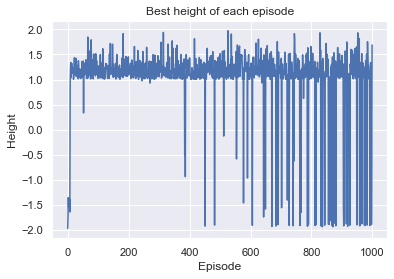

In [10]:
plt.plot(best_episode_height)
plt.title("Best height of each episode")
plt.xlabel("Episode")
plt.ylabel("Height")

Text(0, 0.5, 'Reward')

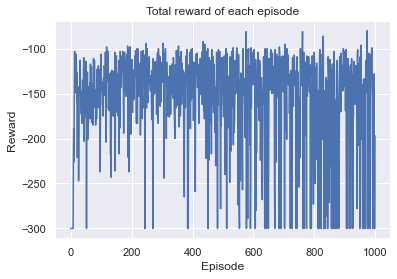

In [11]:
plt.plot(reward_history)
plt.title("Total reward of each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

In [15]:
def test_run(env, model, n_episodes, n_steps, fps=20, visualization=False):
    #setupvariables
    N=n_episodes
    success_growths = []
    first_successful_steps = []
    successful_stepss = []

    for n in range(N):
        state = env.reset()
        steps = n_steps
        successful_steps = 0
        first_successful_step = steps
        success_growth = []
        first_success = False
        for i in range(steps):
            if visualization==True:
                time.sleep(1/fps)
                env.render()
            Q = model(Variable(torch.from_numpy(state).type(torch.FloatTensor))).detach().numpy()
            action = np.argmax(Q)
            state, reward, done, _ = env.step(action)
            
            current_height = get_height(state)

            if current_height>1:
                successful_steps += 1
                if first_success == False:
                    first_success = True
                    first_successful_step = i
            success_growth.append(successful_steps)
        success_growths.append(success_growth)
        first_successful_steps.append(first_successful_step)
        successful_stepss.append(successful_steps)

    print('avg successful steps: {} - {:.4f}%'.format(np.mean(successful_stepss), np.mean(successful_stepss)/steps*100))
    env.close()

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    for n in range(N):
        ax.plot(success_growths[n],'--')
    ax.plot(np.mean(success_growths, axis=0),'.')
    ax.set_title("Average successful steps from {} sample runs".format(N))
    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Successful Steps")
    return np.mean(success_growths, axis=0),first_successful_steps

avg successful steps: 21.47 - 7.1567%


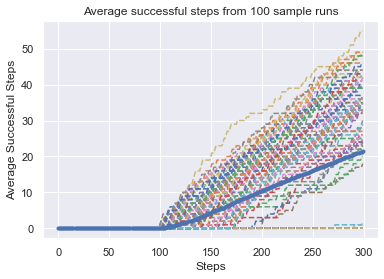

In [16]:
QL_avg_success,first_successful_steps = test_run(env, model1, 100, n_steps=300, fps=30, visualization=False)

In [22]:
%store QL_avg_success

Stored 'QL_avg_success' (ndarray)


In [21]:
np.where(QL_avg_success!=0)[0][0]

100

Código basado en la siguientes referencias:
 - https://github.com/PongC/AcrobotRL/blob/master/my_qlearning.py